In [1]:
import numpy 
import matplotlib.pyplot as plt
import pandas 
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

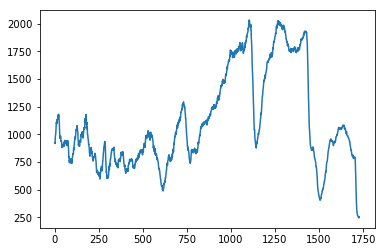

In [3]:
data = pandas.read_csv('DNEdited_weekly_rigs_and_oil_price.csv')
dataframe = pandas.read_csv('DNEdited_weekly_rigs_and_oil_price.csv',usecols=[3], engine='python')
data = data.reindex(index=data.index[::-1])
dataframe = dataframe.reindex(index=dataframe.index[::-1])
dataframe
dataset = dataframe.values
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

In [4]:
data

,Date,WTI_Oil_Price,Brent_Oil_Price,Rigs_Count
1728,7/17/1987,22.03,20.20,922
1727,7/24/1987,21.50,20.19,917
1726,7/31/1987,21.25,19.86,973
1725,8/7/1987,21.52,20.16,983
1724,8/14/1987,20.80,19.41,998
...,...,...,...,...
4,7/31/2020,40.69,43.22,251
3,8/7/2020,41.57,44.36,247
2,8/14/2020,42.08,44.54,244
1,8/21/2020,42.73,44.79,254


In [5]:
dataset

array([[922.],
       [917.],
       [973.],
       ...,
       [244.],
       [254.],
       [254.]], dtype=float32)

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# split into train and test sets, 80% used for training
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1383 346


In [8]:
#This default will create a dataset where X is the number of rigs count at a given time (t) and Y is the number of rigs count at the next time (t + 1).
# convert an array of values into a dataset matrix, pay attention to look_back: its a timestep
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [9]:
dataset

array([[0.37940684],
       [0.37660882],
       [0.40794626],
       ...,
       [0.        ],
       [0.00559597],
       [0.00559597]], dtype=float32)

In [10]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
trainX, trainY, testX, testY

(array([[0.37940684],
        [0.37660882],
        [0.40794626],
        ...,
        [0.8606603 ],
        [0.852826  ],
        [0.8466704 ]], dtype=float32),
 array([0.37660882, 0.40794626, 0.41354224, ..., 0.852826  , 0.8466704 ,
        0.84331286], dtype=float32),
 array([[0.85786235],
        [0.85786235],
        [0.86233914],
        [0.8545048 ],
        [0.8505876 ],
        [0.8545048 ],
        [0.85338557],
        [0.86625624],
        [0.8757694 ],
        [0.87241185],
        [0.8757694 ],
        [0.88080585],
        [0.8880806 ],
        [0.8880806 ],
        [0.9048685 ],
        [0.90095127],
        [0.90151095],
        [0.9048685 ],
        [0.9026301 ],
        [0.90766644],
        [0.9043089 ],
        [0.90095127],
        [0.90318966],
        [0.91158366],
        [0.91214323],
        [0.9127028 ],
        [0.9104644 ],
        [0.9171796 ],
        [0.92053723],
        [0.9311695 ],
        [0.9339676 ],
        [0.92445433],
        [0.93452716],
  

In [12]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
trainX, testX

(array([[[0.37940684]],
 
        [[0.37660882]],
 
        [[0.40794626]],
 
        ...,
 
        [[0.8606603 ]],
 
        [[0.852826  ]],
 
        [[0.8466704 ]]], dtype=float32),
 array([[[0.85786235]],
 
        [[0.85786235]],
 
        [[0.86233914]],
 
        [[0.8545048 ]],
 
        [[0.8505876 ]],
 
        [[0.8545048 ]],
 
        [[0.85338557]],
 
        [[0.86625624]],
 
        [[0.8757694 ]],
 
        [[0.87241185]],
 
        [[0.8757694 ]],
 
        [[0.88080585]],
 
        [[0.8880806 ]],
 
        [[0.8880806 ]],
 
        [[0.9048685 ]],
 
        [[0.90095127]],
 
        [[0.90151095]],
 
        [[0.9048685 ]],
 
        [[0.9026301 ]],
 
        [[0.90766644]],
 
        [[0.9043089 ]],
 
        [[0.90095127]],
 
        [[0.90318966]],
 
        [[0.91158366]],
 
        [[0.91214323]],
 
        [[0.9127028 ]],
 
        [[0.9104644 ]],
 
        [[0.9171796 ]],
 
        [[0.92053723]],
 
        [[0.9311695 ]],
 
        [[0.9339676 ]],
 
        

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [14]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1381/1381 - 1s - loss: 0.1007
Epoch 2/100
1381/1381 - 1s - loss: 0.0209
Epoch 3/100
1381/1381 - 1s - loss: 3.0142e-04
Epoch 4/100
1381/1381 - 1s - loss: 1.4689e-04
Epoch 5/100
1381/1381 - 1s - loss: 1.4069e-04
Epoch 6/100
1381/1381 - 1s - loss: 1.3414e-04
Epoch 7/100
1381/1381 - 1s - loss: 1.3565e-04
Epoch 8/100
1381/1381 - 1s - loss: 1.3242e-04
Epoch 9/100
1381/1381 - 1s - loss: 1.3382e-04
Epoch 10/100
1381/1381 - 1s - loss: 1.3320e-04
Epoch 11/100
1381/1381 - 1s - loss: 1.3178e-04
Epoch 12/100
1381/1381 - 1s - loss: 1.3545e-04
Epoch 13/100
1381/1381 - 1s - loss: 1.3237e-04
Epoch 14/100
1381/1381 - 1s - loss: 1.3183e-04
Epoch 15/100
1381/1381 - 1s - loss: 1.3217e-04
Epoch 16/100
1381/1381 - 1s - loss: 1.3304e-04
Epoch 17/100
1381/1381 - 1s - loss: 1.3307e-04
Epoch 18/100
1381/1381 - 1s - loss: 1.3272e-04
Epoch 19/100
1381/1381 - 1s - loss: 1.2811e-04
Epoch 20/100
1381/1381 - 1s - loss: 1.3032e-04
Epoch 21/100
1381/1381 - 1s - loss: 1.3127e-04
Epoch 22/100
1381/1381 - 1s - 

In [16]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20.47 RMSE
Test Score: 24.52 RMSE


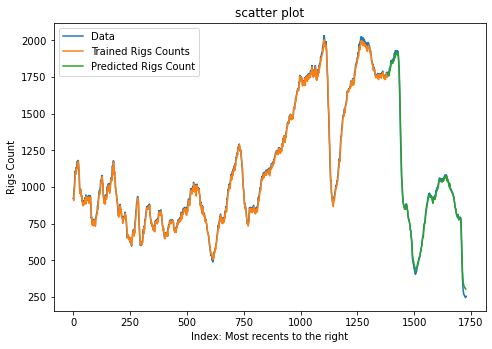

In [39]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.plot(scaler.inverse_transform(dataset),label = "Data")
ax.plot(trainPredictPlot,label = "Trained Rigs Counts")
ax.plot(testPredictPlot,label= "Predicted Rigs Count")
ax.set_xlabel('Index: Most recents to the right')
ax.set_ylabel('Rigs Count')
ax.set_title('scatter plot')
plt.legend()
plt.show()
# plt.plot(scaler.inverse_transform(dataset),label = "Data")
# plt.plot(trainPredictPlot,label = "Trained Rigs Counts")
# plt.plot(testPredictPlot,label= "Predicted Rigs Count")
# plt.figure(figsize=(30,20))
# plt.legend()
# plt.show()

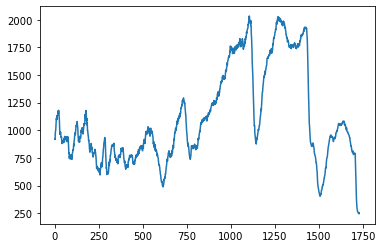

In [18]:
plt.plot(scaler.inverse_transform(dataset))

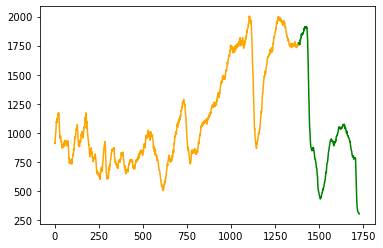

In [19]:
plt.plot(trainPredictPlot,'orange')
plt.plot(testPredictPlot,'green')

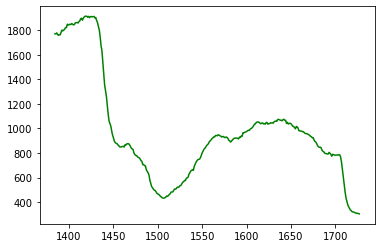

In [20]:
plt.plot(testPredictPlot,'green')

In [21]:
scaler.inverse_transform(dataset), trainPredictPlot, testPredictPlot

(array([[922.     ],
        [916.99994],
        [972.99994],
        ...,
        [244.     ],
        [254.     ],
        [254.     ]], dtype=float32),
 array([[     nan],
        [912.1371],
        [907.1659],
        ...,
        [     nan],
        [     nan],
        [     nan]], dtype=float32),
 array([[      nan],
        [      nan],
        [      nan],
        ...,
        [305.78253],
        [303.47424],
        [      nan]], dtype=float32))

In [22]:
scaler.inverse_transform(dataset).shape

(1729, 1)

In [23]:
 trainPredictPlot.shape

(1729, 1)

In [24]:
testPredictPlot.shape

(1729, 1)

In [35]:
Results_LSTM_RigsBasedOnPastRigs = {'Rigs Count':scaler.inverse_transform(dataset), 'Train Predict Plot':trainPredictPlot, 'Test Predict Plot':testPredictPlot}
Results_LSTM_RigsBasedOnPastRigs = pandas.DataFrame(data=Results_LSTM_RigsBasedOnPastRigs)
Results_LSTM_RigsBasedOnPastRigs

ValueError: If using all scalar values, you must pass an index